In [1]:
import numpy as np

import pandas as pd
from collections import defaultdict
import string

import sklearn
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt

from utils import preprocess
np.random.seed(1234)

In [2]:
num_split = 5

In [3]:
df = pd.read_csv('./data/train_feature.csv')
df_test = pd.read_csv('./data/test_feature.csv')
text = df.text.values
text_test = df_test.text.values

author2class = {'EAP': 0, 'HPL' : 1, 'MWS' : 2}
class2author = ['EAP', 'HPL', 'MWS']
y = np.array([author2class[a] for a in df.author])

In [4]:
# df
df.drop('id', axis=1, inplace=True)
df.drop('text', axis=1, inplace=True)
df.drop('author', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('Unnamed: 0.1', axis=1, inplace=True)
df.drop('Unnamed: 0.1.1', axis=1, inplace=True)

In [5]:
df_test.drop('id', axis=1, inplace=True)
df_test.drop('text', axis=1, inplace=True)
df_test.drop('Unnamed: 0', axis=1, inplace=True)
df_test.drop('Unnamed: 0.1', axis=1, inplace=True)
df_test.drop('Unnamed: 0.1.1', axis=1, inplace=True)

In [6]:
scale_targets = [k for k in df.keys() if 'num' in k]
', '.join(scale_targets)

'num_words, num_chars, average_num_chars, num_uniq_words, num_uniq_chars, num_,'

In [7]:
len(df.keys()), len(df_test.keys())

(41, 41)

In [8]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.1 #01
param['max_depth'] = 2
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 0.8
param['colsample_bytree'] = 0.3
param['seed'] = 7
num_rounds = 6000

cv_scores = []
kf = KFold(n_splits=num_split, shuffle=True, random_state=2017)
results = np.zeros((len(df_test), 3))
for train_ids, val_ids in kf.split(df):
    x_train, x_val = df.loc[train_ids], df.loc[val_ids]
    y_train, y_val = y[train_ids], y[val_ids]
    print(len(x_train), len(x_val))
    
    # no sense ?
    #     for k in scale_targets:
    #         scaler = MinMaxScaler()
    #         x_train[k] = scaler.fit_transform(x_train[k].values.reshape(len(x_train[k]), 1)).reshape(-1)
    #         x_val[k] = scaler.transform(x_val[k].values.reshape(len(x_val[k]), -1)).reshape(-1)
    #         df_test[k] = scaler.transform(df_test[k].values.reshape(len(df_test[k]), -1)).reshape(-1)
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(x_train, label=y_train)
    xgtest = xgb.DMatrix(x_val, label=y_val)
    
    watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
    model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=170, verbose_eval=50)
    

    xgtest2 = xgb.DMatrix(df_test)
    results += model.predict(xgtest2, ntree_limit=model.best_ntree_limit)


15663 3916
[0]	train-mlogloss:1.00114	test-mlogloss:1.00124
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 170 rounds.
[50]	train-mlogloss:0.286255	test-mlogloss:0.287596
[100]	train-mlogloss:0.259621	test-mlogloss:0.270817
[150]	train-mlogloss:0.246516	test-mlogloss:0.265625
[200]	train-mlogloss:0.237191	test-mlogloss:0.263698
[250]	train-mlogloss:0.229783	test-mlogloss:0.262847
[300]	train-mlogloss:0.222967	test-mlogloss:0.26221
[350]	train-mlogloss:0.21688	test-mlogloss:0.261739
[400]	train-mlogloss:0.21136	test-mlogloss:0.261953
[450]	train-mlogloss:0.206107	test-mlogloss:0.262471
[500]	train-mlogloss:0.201079	test-mlogloss:0.263131
Stopping. Best iteration:
[366]	train-mlogloss:0.215144	test-mlogloss:0.261379

15663 3916
[0]	train-mlogloss:1.00104	test-mlogloss:1.00228
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss h

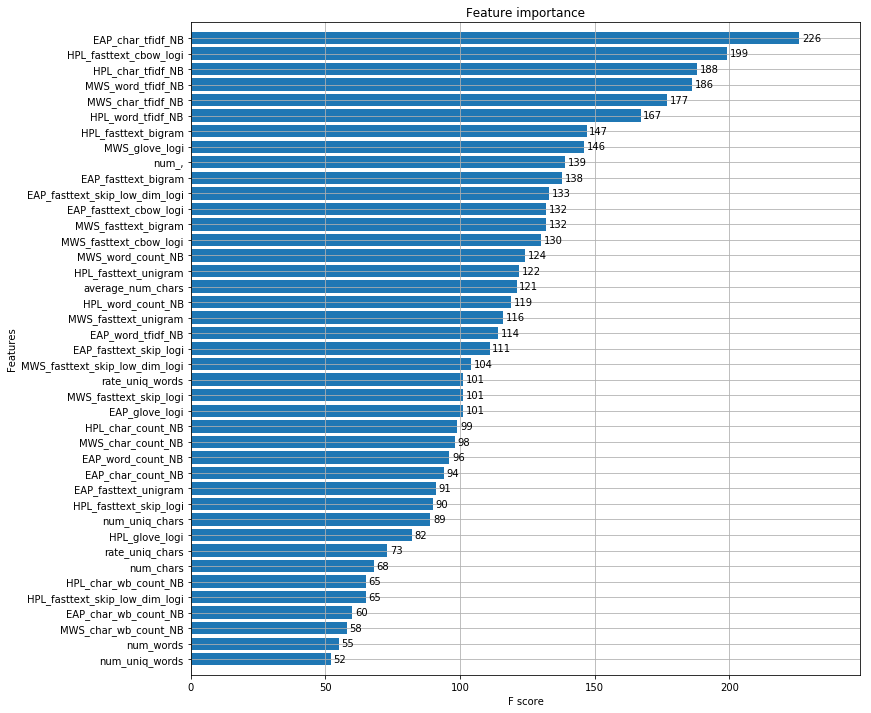

In [9]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [10]:
submission_df = pd.read_csv('./data/sample_submission.csv')
for a, i in author2class.items():
    submission_df[a] = results[:, i]/num_split

with open('./results/fix_preprocess_xbgoost.csv', 'w') as f:
    f.write('"id","EAP","HPL","MWS"\n')
    for (index, row) in submission_df.iterrows():
        f.write(','.join(['\"' + row['id'] + '\"'] +  list(map(str, [row['EAP'], row['HPL'], row['MWS']]))) + '\n')